## 0) Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sktime.utils.plotting import plot_series

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,6)

## 1) Define the Business Goal

Build a model that can predict tomorrow's temperature as precisely as possible.

## 2) Get the Data

### 2.1) Load the Data

In [2]:
df = pd.read_csv('./TG_STAID000186.csv', index_col=1, parse_dates=True)
#df= pd.read_csv('./TG_STAID019003.csv', index_col=1, parse_dates=True)
#df = pd.read_csv('./TG_STAID002759.csv', index_col=1, parse_dates=True)


In [3]:
df.describe()

,SOUID,TG,Q_TG
count,40086.000000,40086.000000,40086.000000
mean,159073.194756,-2845.863294,2.528090
std,49452.881998,4471.452941,4.044969
min,100580.000000,-9999.000000,0.000000
25%,100580.000000,-9999.000000,0.000000
50%,200882.000000,-99.000000,0.000000
75%,200882.000000,3.000000,9.000000
max,200882.000000,174.000000,9.000000


In [4]:
df.value_counts([df['TG']==-9999])/len(df)

TG   
False    0.719104
True     0.280896
dtype: float64

In [5]:
df['TG'] = df['TG'].replace(-9999,np.NaN)

In [6]:
df.describe()

,SOUID,TG,Q_TG
count,40086.000000,28826.000000,40086.000000
mean,159073.194756,-51.708041,2.528090
std,49452.881998,94.474781,4.044969
min,100580.000000,-436.000000,0.000000
25%,100580.000000,-119.000000,0.000000
50%,200882.000000,-36.000000,0.000000
75%,200882.000000,26.000000,9.000000
max,200882.000000,174.000000,9.000000


In [7]:
# extract year
df['year'] = df.index.year   
#df['month'] = df.index.month
#df['day'] = df.index.day
#df.head()

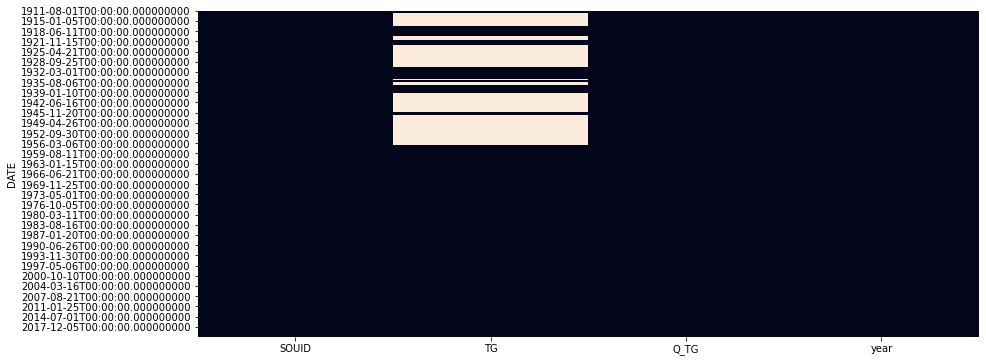

In [8]:
sns.heatmap(df.isna(), cbar=False);

In [9]:
#sns.heatmap(df[df['year']== 1945].isna(), cbar=False);

### 2.2) Clean the Data

In [10]:
df['TG'] = df['TG']/10

In [11]:
# only take year 1957+ due to missings in the periods before
df_clean = df[df['year']>=1957][['TG']]
df_clean

,TG
DATE,
1957-01-01,-5.7
1957-01-02,-6.5
1957-01-03,-6.5
1957-01-04,-0.3
1957-01-05,0.5
...,...
2021-04-26,-7.0
2021-04-27,-7.7
2021-04-28,-6.6


## 3) Train-Test-Split

In [12]:
df_train = df_clean[:-365]

df_test = df_clean[-365:]

## 4) Visualize the Data

<AxesSubplot:xlabel='DATE'>

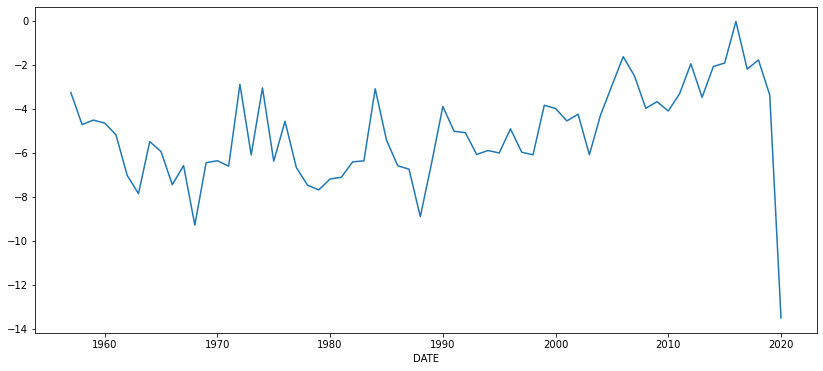

In [13]:
df_train.groupby(df_train.index.year)['TG'].mean().plot()

In [14]:
#df_train['TG'].resample('2M').mean().plot()

<AxesSubplot:xlabel='DATE'>

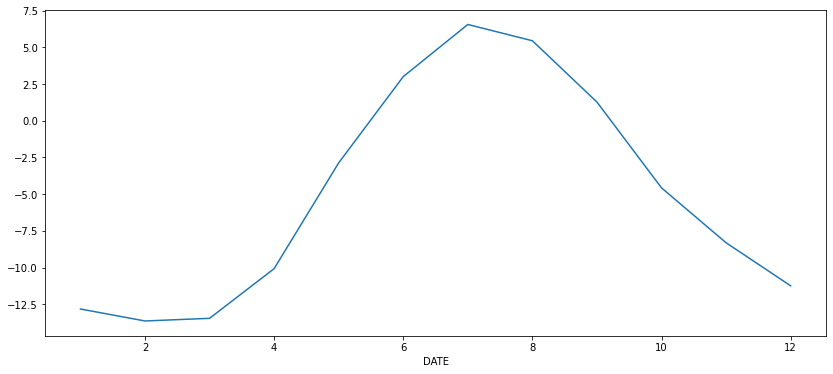

In [15]:
df_train.groupby(df_train.index.month)['TG'].mean().plot()

## 5) Feature Engineer

## 6) Train a model

### Model Trend

In [16]:
df_train['timestep'] = range(len(df_train))

In [17]:
X = df_train[['timestep']]

y = df_train['TG']

In [18]:
m = LinearRegression()

m.fit(X, y)

LinearRegression()

In [19]:
m.coef_, m.intercept_

(array([0.00016225]), -6.922374072482219)

In [20]:
df_train['trend'] = m.predict(X)

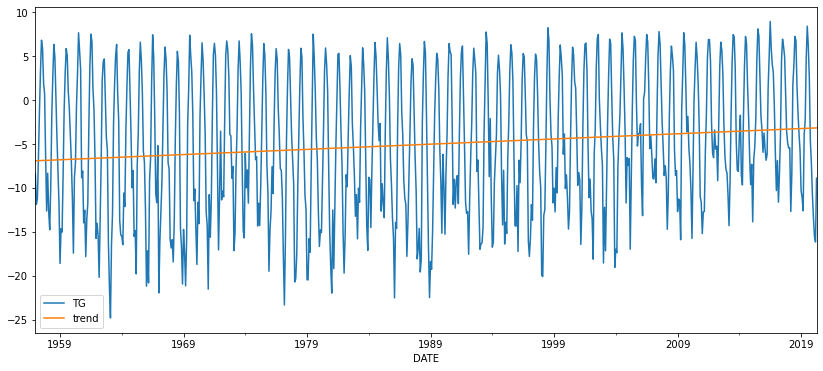

In [21]:
df_train.resample('1M').mean()[['TG', 'trend']].plot();
#df_clean[df_clean['year']>2015][['TG', 'trend']].plot()

## Seasonality

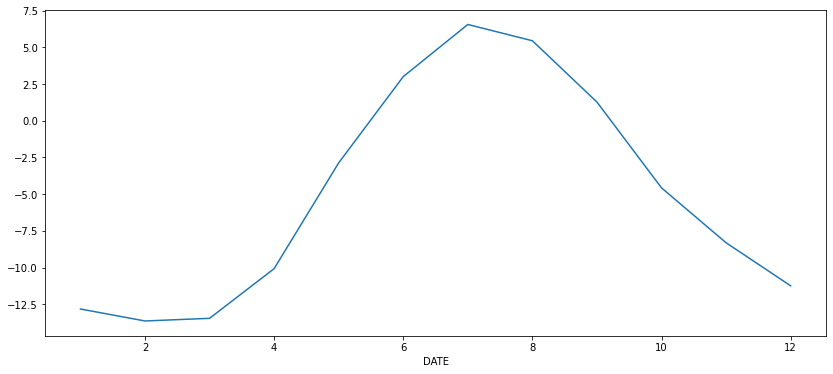

In [22]:
df_train.groupby(df_train.index.month)['TG'].mean().plot();

In [23]:
#month_dummies = pd.get_dummies(df_train.index.month, prefix='month').set_index(df_train.index)

day_dummies = pd.get_dummies(df_train.index.dayofyear, prefix='day').set_index(df_train.index)

In [24]:
df_train = df_train.join(day_dummies)
#df_train

In [25]:
X = df_train.drop(['TG','trend'], axis=1)

In [26]:
m2 = LinearRegression()
m2.fit(X, y)

LinearRegression()

In [27]:
df_train['trend_seasonal'] = m2.predict(X)

In [ ]:
df_train[['TG', 'trend_seasonal']].plot() #### HERE!!!

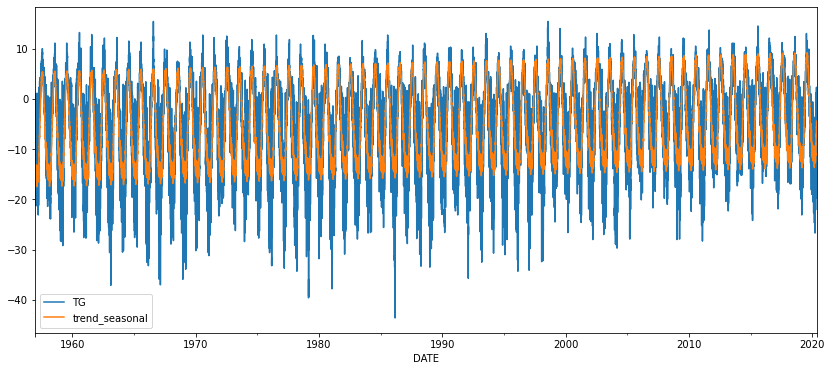

In [28]:
#df_train[df_train.index.year >2019][['TG', 'trend_seasonal']].plot();
df_train[['TG', 'trend_seasonal']].plot();

In [29]:
df_train['remainder'] = df_train['TG'] - df_train['trend_seasonal']

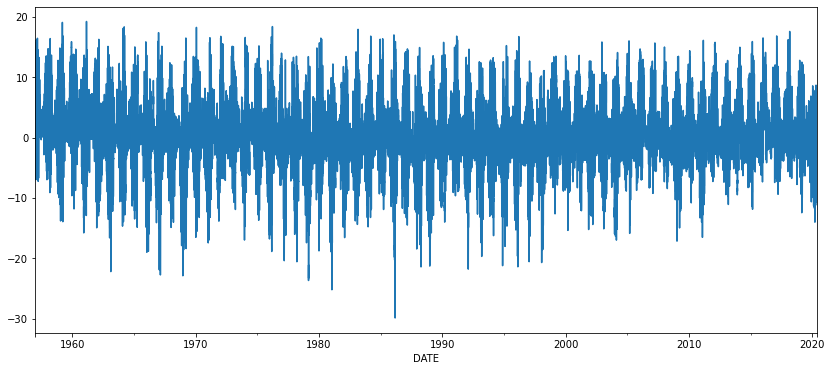

In [30]:
#df_train[df_train.index.year >2019]['remainder'].plot();
df_train['remainder'].plot();

## statsmodels

In [31]:
#sd = seasonal_decompose(df_train[df_train.index.year >2019]['TG'])
sd = seasonal_decompose(df_train['TG'])

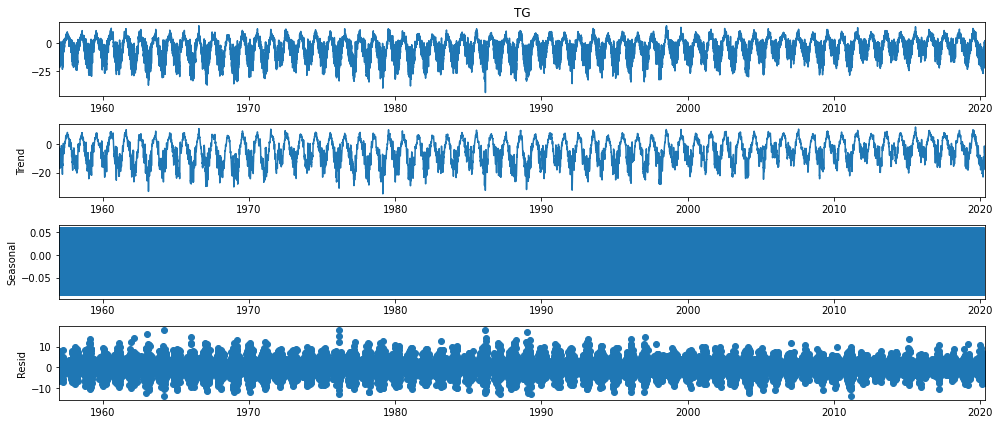

In [32]:
sd.plot();

### Add lag feature — for modeling remainder

In [33]:
df_train['lag1'] = df_train['remainder'].shift(1)

df_train.head(3)

,TG,timestep,trend,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_360,day_361,day_362,day_363,day_364,day_365,day_366,trend_seasonal,remainder,lag1
DATE,,,,,,,,,,,,,,,,,,,,,
1957-01-01,-5.7,0,-6.922374,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-14.563317,8.863317,NaN
1957-01-02,-6.5,1,-6.922212,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-14.683629,8.183629,8.863317
1957-01-03,-6.5,2,-6.922050,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,-14.677379,8.177379,8.183629


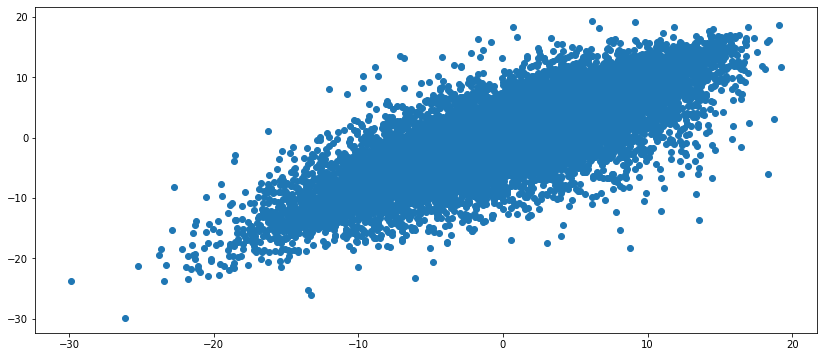

In [34]:
plt.scatter(x='remainder', y='lag1', data=df_train)

In [35]:
df_train[['remainder','lag1']].corr()

,remainder,lag1
remainder,1.000000,0.803441
lag1,0.803441,1.000000


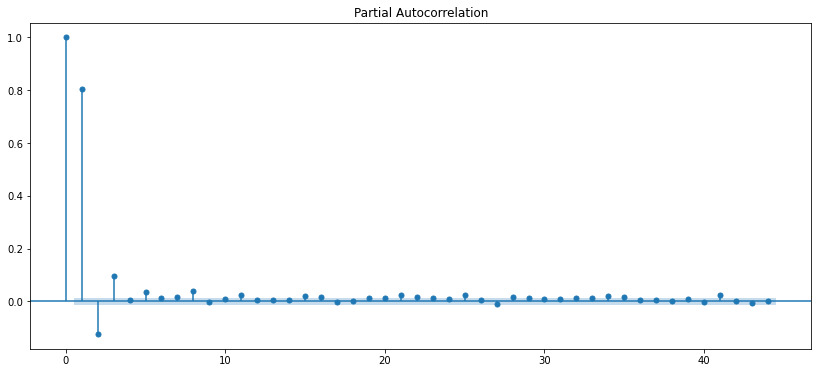

In [36]:
plot_pacf(df_train['remainder']);

In [37]:
# in shaded area is 95% CI, show stat independence

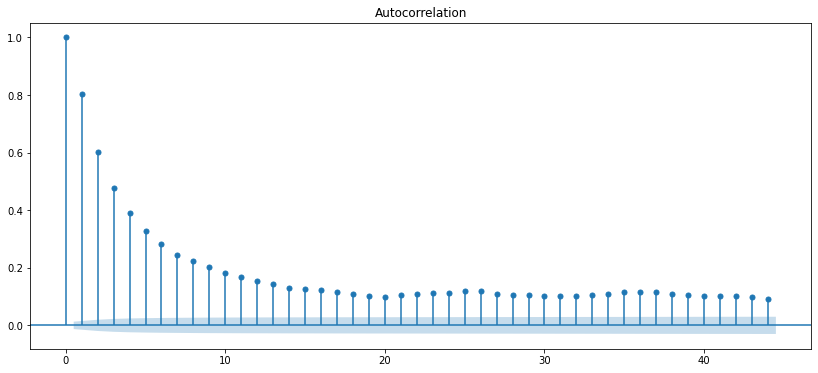

In [38]:
plot_acf(df_train['remainder']);

In [96]:
selected_order = ar_select_order(df_train['remainder'], maxlag=20)

In [97]:
selected_order.ar_lags

array([1, 2, 3, 4, 5, 6, 7, 8])

In [98]:
#selected_order.bic # first row and then the drop

In [42]:
# Define X and y for full model
df_train.dropna(inplace=True)
X_full = df_train.drop(['TG','trend','trend_seasonal','remainder'], axis=1)
y_full = df_train['TG']

In [43]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [44]:
df_train['full_model'] = m_full.predict(X_full)

<AxesSubplot:xlabel='DATE'>

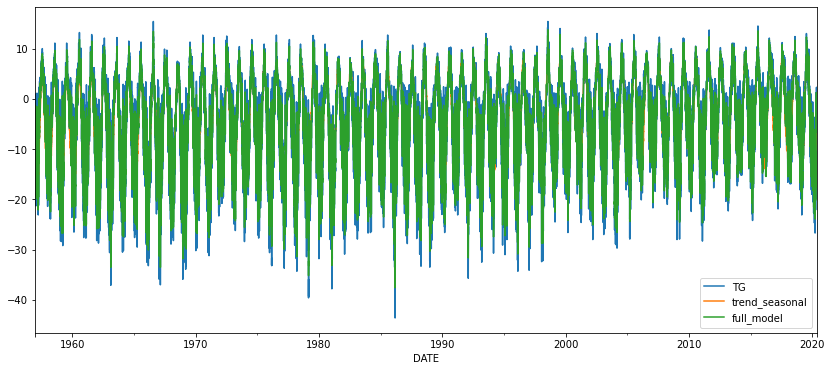

In [45]:
df_train[['TG', 'trend_seasonal', 'full_model']].plot()

In [46]:
df_train['remainder_full_model'] = df_train['TG'] - df_train['full_model']

<AxesSubplot:xlabel='DATE'>

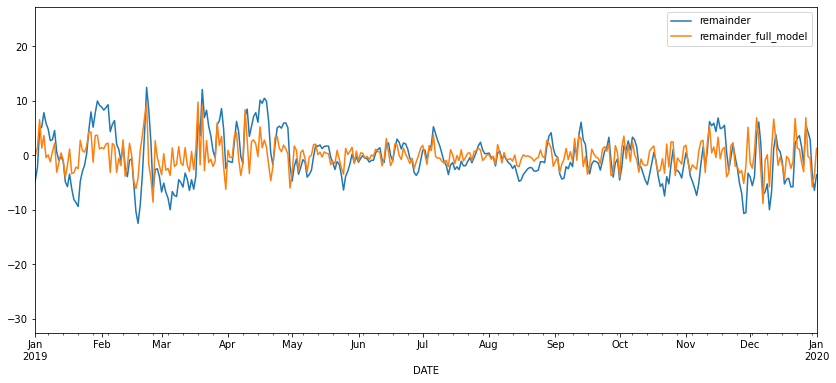

In [47]:
#df_train[df_train.index.year >2019][['remainder', 'remainder_full_model']].plot()
df_train[['remainder', 'remainder_full_model']].plot(xlim=('2019','2020'))

In [48]:
df_train.drop('remainder_full_model', axis=1, inplace=True)

## 7) Cross-Validate and Optimize Hyperparameters

In [57]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [58]:
X_full.shape

(23130, 368)

In [59]:
# See how the folds work: 
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index[0]} to {train_index[-1]}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index[0]} to {validation_index[-1]}')
    print()

The training data for the 1th iteration are the observations 0 to 3854
The validation data for the 1th iteration are the observations 3855 to 7709

The training data for the 2th iteration are the observations 0 to 7709
The validation data for the 2th iteration are the observations 7710 to 11564

The training data for the 3th iteration are the observations 0 to 11564
The validation data for the 3th iteration are the observations 11565 to 15419

The training data for the 4th iteration are the observations 0 to 15419
The validation data for the 4th iteration are the observations 15420 to 19274

The training data for the 5th iteration are the observations 0 to 19274
The validation data for the 5th iteration are the observations 19275 to 23129



In [60]:
time_series_split = ts_split.split(X_full, y_full)

In [62]:
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)

In [63]:
result

array([0.84593051, 0.85702459, 0.86063218, 0.86861406, 0.87369509])

In [ ]:
round(result.mean(), 3)

## 8) Test

In [ ]:
last_train_timestep = df_train['timestep'][-1]

In [ ]:
last_train_timestep

In [ ]:
df_test['timestep'] = range(last_train_timestep+1, last_train_timestep+1+len(df_test))

In [ ]:
df_test

In [ ]:
#seasonal_dummies = pd.get_dummies(df_test.index.month, prefix='month').set_index(df_test.index)
seasonal_dummies = pd.get_dummies(df_test.index.dayofyear, prefix='day').set_index(df_test.index)

In [ ]:
df_test = df_test.join(seasonal_dummies)
df_test['day_121'] = 0

In [ ]:
# Assign X_test
X_test = df_test.drop('TG', axis=1)

In [ ]:
################################
X_test.columns

In [ ]:
pd.set_option('display.max_columns', None)
X.head()
#print(X.columns)

In [ ]:
X_test.head()

In [ ]:
X[X['day_121']==1]['day_121']

In [ ]:
X_test.shape, X.shape

In [ ]:
# Predict trend-seasonal component
df_test['trend_seasonal'] = m2.predict(X_test)

In [ ]:
df_test[['TG', 'trend_seasonal']].plot() #### HERE!!!

In [ ]:
# Calculate the remainder
df_test['remainder'] = df_test['TG'] - df_test['trend_seasonal']

In [ ]:
# Add the lag1 feature
df_test['lag1'] = df_test['remainder'].shift(1)

In [ ]:
df_test

In [ ]:
# Fill in the NaN in the lag1 column
df_test.loc['2020-05-01', 'lag1'] = df_train.loc['2020-04-30', 'remainder']

In [ ]:
# Assign X_full
X_full = df_test.drop(['TG', 'trend_seasonal', 'remainder'], axis=1)

In [ ]:
# Create predictions
df_test['full_model'] = m_full.predict(X_full)

In [ ]:
df_full = df_train[['TG', 'trend_seasonal', 'full_model']]\
    .append(df_test[['TG', 'trend_seasonal', 'full_model']])

In [ ]:
df_full.plot()

In [ ]:
round(m_full.score(X_full, df_test['TG']), 3)

## Predict the future

In [ ]:
# Combine the datasets
df_combined = df_train.append(df_test)

In [ ]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['TG','trend', 'trend_seasonal', 'remainder', 'full_model','prediction_sm'])
y_combined = df_combined['TG']

In [ ]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

In [ ]:
df_combined

### Components of the future

In [ ]:
timestep = df_combined['timestep'].max() + 1
days = [0] * 366
days[120] = 1
lag = df_combined.loc['2021-04-30', 'remainder']

In [ ]:
# Create a future data point
X_future1 = []
X_future1.append(timestep)
X_future1.extend(days)
X_future1.append(lag)

In [ ]:
X_future1 = pd.DataFrame([X_future1], columns = X_combined.columns)

In [ ]:
m_combined.predict(X_future1)

In [ ]:
# How does this look like for the next day?
timestep = df_combined['timestep'].max() + 2
days = [0] * 366
days[121] = 1
lag = 0
# This is too far in the future to calculate lag, 
# we don't have remainder for the previous data point (X_future1),
# this is now only modeling trend-seasonal component

In [ ]:
X_future2 = pd.DataFrame([[timestep] + days + [lag]], columns = X_combined.columns)

In [ ]:
m_combined.predict(X_future2)

## Run autoregression model

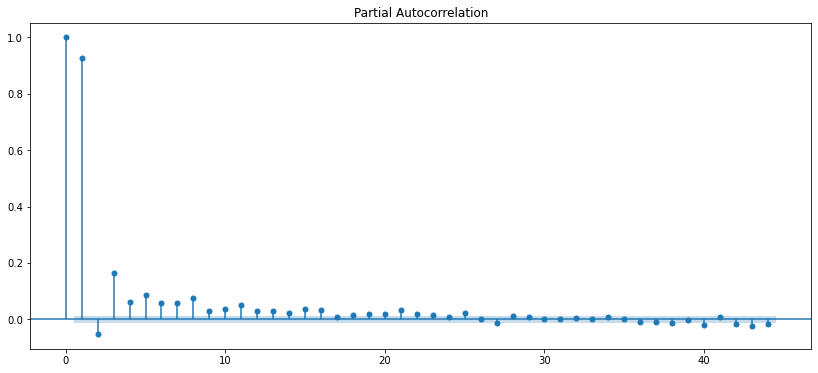

In [99]:
plot_pacf(df_train['TG']);

In [37]:
# in shaded area is 95% CI, show stat independence

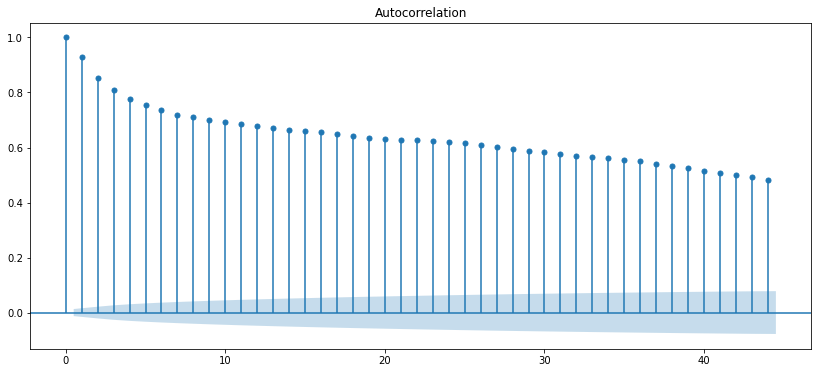

In [100]:
plot_acf(df_train['TG']);

In [101]:
selected_order = ar_select_order(df_train['TG'], maxlag=20)

In [102]:
selected_order.ar_lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [98]:
#selected_order.bic # first row and then the drop

In [73]:
ar_model = AutoReg(endog=df_train['TG'], lags=1).fit()

<AxesSubplot:xlabel='DATE'>

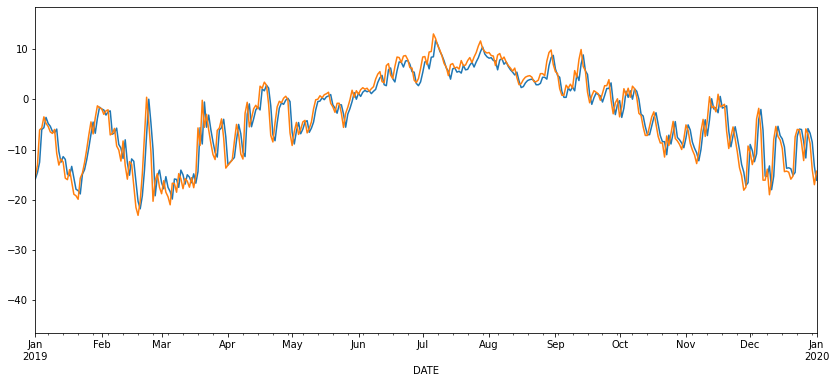

In [111]:
ar_model.predict().plot()
df_train['TG'].plot(xlim=('2019','2020'))


In [75]:
df_train['prediction_sm'] = ar_model.predict()

In [76]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                     TG   No. Observations:                23130
Model:                     AutoReg(1)   Log Likelihood              -61665.844
Method:               Conditional MLE   S.D. of innovations              3.481
Date:                Fri, 04 Jun 2021   AIC                              2.495
Time:                        14:30:46   BIC                              2.496
Sample:                    01-03-1957   HQIC                             2.495
                         - 04-30-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3622      0.026    -13.928      0.000      -0.413      -0.311
TG.L1          0.9282      0.002    379.295      0.000       0.923       0.933
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0774           +0.0000j            1.0774            0.0000
-----------------------------------------------------------------------------
"""

In [94]:
y_true = df_train.iloc[1:]['TG']
y_pred = df_train.iloc[1:]['prediction_sm']

In [95]:
r2_score(y_true, y_pred)

0.8614980508326576

In [77]:
ar_model2 = AutoReg(endog=df_train['TG'], lags=16).fit()

<AxesSubplot:xlabel='DATE'>

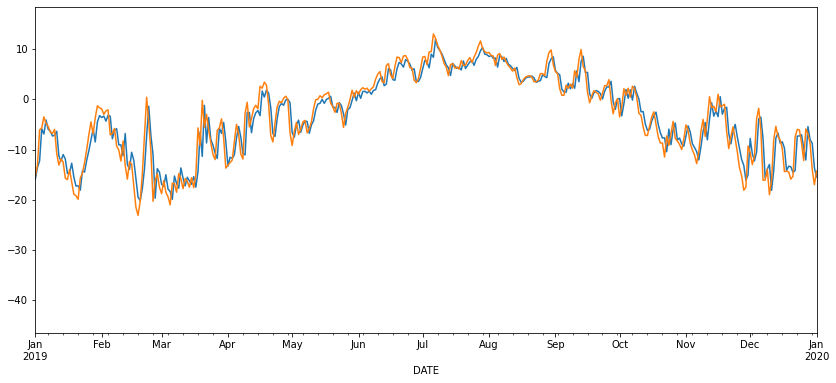

In [110]:
ar_model2.predict().plot()
df_train['TG'].plot(xlim=('2019','2020'))


In [79]:
df_train['prediction_sm2'] = ar_model2.predict()

In [80]:
ar_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                     TG   No. Observations:                23130
Model:                    AutoReg(16)   Log Likelihood              -60888.434
Method:               Conditional MLE   S.D. of innovations              3.371
Date:                Fri, 04 Jun 2021   AIC                              2.432
Time:                        14:31:21   BIC                              2.438
Sample:                    01-18-1957   HQIC                             2.434
                         - 04-30-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1696      0.026     -6.523      0.000      -0.221      -0.119
TG.L1          0.9462      0.007    143.928      0.000       0.933       0.959
TG.L2         -0.2107      0.009    -23.274      0.000      -0.228      -0.193
TG.L3          0.1078      0.009     11.769      0.000       0.090       0.126
TG.L4         -0.0193      0.009     -2.102      0.036      -0.037      -0.001
TG.L5          0.0314      0.009      3.421      0.001       0.013       0.049
TG.L6          0.0122      0.009      1.325      0.185      -0.006       0.030
TG.L7         -0.0147      0.009     -1.597      0.110      -0.033       0.003
TG.L8          0.0469      0.009      5.101      0.000       0.029       0.065
TG.L9          0.0020      0.009      0.214      0.831      -0.016       0.020
TG.L10        -0.0097      0.009     -1.052      0.293      -0.028       0.008
TG.L11         0.0255      0.009      2.780      0.005       0.008       0.044
TG.L12         0.0027      0.009      0.290      0.771      -0.015       0.021
TG.L13         0.0133      0.009      1.451      0.147      -0.005       0.031
TG.L14        -0.0071      0.009     -0.771      0.441      -0.025       0.011
TG.L15         0.0084      0.009      0.928      0.354      -0.009       0.026
TG.L16         0.0313      0.007      4.763      0.000       0.018       0.044
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0145           -0.0000j            1.0145           -0.0000
AR.2             1.0963           -0.4050j            1.1687           -0.0563
AR.3             1.0963           +0.4050j            1.1687            0.0563
AR.4             0.9101           -0.7981j            1.2105           -0.1146
AR.5             0.9101           +0.7981j            1.2105            0.1146
AR.6             0.5528           -1.1043j            1.2349           -0.1761
AR.7             0.5528           +1.1043j            1.2349            0.1761
AR.8             0.0744           -1.2231j            1.2254           -0.2403
AR.9             0.0744           +1.2231j            1.2254            0.2403
AR.10           -0.4621           -1.2066j            1.2921           -0.3082
AR.11           -0.4621           +1.2066j            1.2921            0.3082
AR.12           -0.8596           -0.9396j            1.2735           -0.3679
AR.13           -0.8596           +0.9396j            1.2735            0.3679
AR.14           -1.2550           -0.4919j            1.3479           -0.4405
AR.15           -1.2550           +0.4919j            1.3479            0.4405
AR.16           -1.3967           -0.0000j            1.3967           -0.5000
------------------------------------------------------------------------------
""

In [89]:
y_true = df_train.iloc[16:]['TG']
y_pred = df_train.iloc[16:]['prediction_sm2']

In [91]:
r2_score(y_true, y_pred)

0.8701083050096152

In [103]:
ar_model3 = AutoReg(endog=df_train['TG'], lags=3).fit()

<AxesSubplot:xlabel='DATE'>

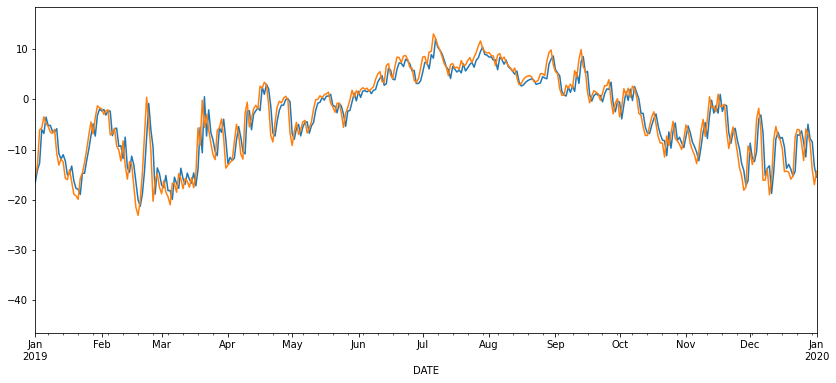

In [112]:
ar_model3.predict().plot()
df_train['TG'].plot(xlim=('2019','2020'))


In [105]:
df_train['prediction_sm3'] = ar_model3.predict()

In [106]:
ar_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                     TG   No. Observations:                23130
Model:                     AutoReg(3)   Log Likelihood              -61308.195
Method:               Conditional MLE   S.D. of innovations              3.428
Date:                Fri, 04 Jun 2021   AIC                              2.464
Time:                        14:43:27   BIC                              2.466
Sample:                    01-05-1957   HQIC                             2.465
                         - 04-30-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3182      0.026    -12.315      0.000      -0.369      -0.268
TG.L1          0.9850      0.006    151.895      0.000       0.972       0.998
TG.L2         -0.2134      0.009    -23.562      0.000      -0.231      -0.196
TG.L3          0.1653      0.006     25.494      0.000       0.153       0.178
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0589           -0.0000j            1.0589           -0.0000
AR.2            0.1160           -2.3872j            2.3900           -0.2423
AR.3            0.1160           +2.3872j            2.3900            0.2423
-----------------------------------------------------------------------------
"""

In [107]:
y_true = df_train.iloc[3:]['TG']
y_pred = df_train.iloc[3:]['prediction_sm3']

In [108]:
r2_score(y_true, y_pred)

0.8656642721198613

## Predict the future II

In [128]:
# Combine the datasets
df_combined = df_train.append(df_test)[['TG','timestep']]

In [130]:
selected_order = ar_select_order(df_combined['TG'], maxlag=20)

In [131]:
selected_order.ar_lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [132]:
ar_model_F = AutoReg(endog=df_combined['TG'], lags=16).fit()

In [133]:
df_train['prediction_sm_F'] = ar_model_F.predict()

### Components of the future

In [134]:
timestep = df_combined['timestep'].max() + 1


In [135]:
# Create a future data point
X_future1 = []
X_future1.append(timestep)
#X_future1.extend(days)
#X_future1.append(lag)

In [136]:
X_future1 = pd.DataFrame([X_future1], columns = ['timestep'])

In [137]:
X_future1

,timestep
0,23131.0


# --------------------------- Parking Lot --------------------------- 

In [ ]:
scaler = StandardScaler() # diff standard to minmax scaler? standard remove mean and devide by std

In [ ]:
X = scaler.fit_transform(np.array(df_clean['TG']).reshape(-1,1))

In [ ]:
X

In [ ]:
p = PolynomialFeatures(degree=3, include_bias=False)
p.fit(X)
Xpoly = p.transform(X)#.astype(int)
Xpoly = pd.DataFrame(Xpoly,columns=[f'poly_{b}' for b in range(len(Xpoly[0]))])
# columns: a, b, a^2, ab, b^2
Xpoly

In [ ]:
m2 = LinearRegression()

In [ ]:
m2.fit(Xpoly, y)

In [ ]:
[t for t in zip(m2.predict(Xpoly), y)]

In [ ]:
m2.coef_, m2.intercept_

In [ ]:
df_clean['trend2'] = m2.predict(Xpoly)

In [ ]:
df_clean[['TG', 'trend2']].plot()

#### -----------------------------------------------


In [ ]:
plot_series(df_train['TG'].resample('1M').mean(), df_test['TG'].resample('1M').mean(), labels=["train", "test"])


#### -------------------------------------------------------------


In [ ]:
#[t for t in zip(m.predict(X), y)]